# Download data and libs

Download data from Google drive and extract

Please change the code if you want to use different data

The extracted folder is saved at the path: /kaggle/working/

In [ ]:
!pip install gdown
!gdown --id 1_9NPC8E-kt4pU6rTi5lkh91eFR_jnFav --output sino_nom.zip
!unzip -u '/kaggle/working/sino_nom.zip'

## Install required libraries


In this notebook, we have used the numpy-stl library to process STL files

In [3]:
!pip install numpy-stl

# Processing 3D STL models

In [1]:
import numpy as np
from stl import mesh
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import io
import cv2

The g_path below is the path to 2 folders: stl file folder and sino_nom character image folder
If you want to run with new data, please check and make sure the path is correct

In [4]:
# g_path = 'wb_2D3Dretrieval_dataset/'
g_path = 'F:/official/images/test_retrieval'

In [5]:
# Folder contain 3D STL files
stl_path = os.path.join(g_path,'database') 

# 3D models -> 2D images
stl_2d_path = os.path.join(g_path,'stl_to_2d')

if not os.path.exists(stl_2d_path):
    os.mkdir(stl_2d_path) 

# Number of stl model
num_file= len(os.listdir(stl_path))

# Queries folder -> Please change the name 'print' to the correct queries folder's name
queries_path =  os.path.join(g_path,'queries') 

# Final result CSV file
csv_path = os.path.join(g_path,'result.csv')


In [20]:
img_size = (256,256)
def crop(image):
    """
    This function will crop the Sino-Nom character inside the bounding box.
    The bounding box will be found by detecting contours.
    Input:
    :param image: the 2D Sino-Nom character image
    Output:
    :return: The image after cropping
    """
    contours, hierarchy = cv2.findContours(image ,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cropped_image = None

    min_x = min_y = float('inf')
    max_x = max_y = 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x==0 or y==0:
            continue
        # Tìm tọa độ min-max
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
    try:
        return cv2.resize(image[min_y:max_y, min_x:max_x], img_size)  
    except:
        return cv2.resize(image[0: 255, 0:255], img_size)

def stl_to_2d(file_path):
    """
    This function will process a 3D model into a 2D image.
    The STL model will be loaded from the given path, then it will be cut 6/7 of its thickness to get the top and saved to a Mesh array.
    After that, we will use the matplotlib library to plot the Mesh file from a specific angle and then save the figure to a buffer.
    Finally, the crop function will be used to crop the 2D image.
    Input:
    :param file_path: the path to the STL file
    Output:
    :return: 2D image generated from the 3D model
    """
    # Load the STL file
    _mesh = mesh.Mesh.from_file(file_path)
    # Compute the bounding box
    min_coords = np.min(_mesh.points, axis=0)
    max_coords = np.max(_mesh.points, axis=0)
    # Choose a cutting axis (e.g., the z-axis)
    cutting_axis = 2  # Assuming z-axis, change if needed
    # Find the coordinate value halfway between the minimum and maximum along the cutting axis
    cutting_plane = min_coords[cutting_axis] + 6*(max_coords[cutting_axis] - min_coords[cutting_axis]) / 7.0
    # Partition the model based on the cutting plane
    vectors_above_plane = []
    for vector in _mesh.vectors:
        # Check if all vertices of the triangle are above the cutting plane
        if np.all(vector[:, cutting_axis] > cutting_plane):
            vectors_above_plane.append(vector)
    # Create a new mesh object from the vectors above the cutting plane
    above_cutting_plane_mesh = mesh.Mesh(np.zeros(len(vectors_above_plane), dtype=mesh.Mesh.dtype))
    above_cutting_plane_mesh.vectors = vectors_above_plane

    figure = plt.figure()
    axes = figure.add_subplot(projection='3d')
    axes.view_init(elev=90, azim=-90)
    # Load the STL files and add the vectors to the plot
    poly_collection = mplot3d.art3d.Poly3DCollection(above_cutting_plane_mesh.vectors)
    poly_collection.set_color((0,0,0))  # play with color
    scale = above_cutting_plane_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    axes.add_collection3d(poly_collection)
    plt.grid(False)
    plt.axis('off')
    # Show the plot to the screen
    buffer = io.BytesIO()
    figure.savefig(buffer, format='jpg')
    buffer.seek(0)
    image_buffer = cv2.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), -1)
    gray = cv2.cvtColor(image_buffer, cv2.COLOR_BGR2GRAY)
    ret,thresh_3d = cv2.threshold(gray,150,255,0)
    image_ = crop(thresh_3d)
    buffer.close()
    plt.close()
    return image_
    

Let's test the stl_to_2d funtion and plot the 2D image

(<matplotlib.image.AxesImage at 0x1def7f5ae00>, (-0.5, 255.5, 255.5, -0.5))

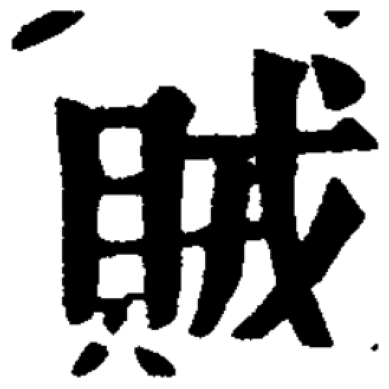

In [17]:
plt.imshow(stl_to_2d(f'{g_path}/database/17.stl'), cmap = 'gray'), plt.axis('off')

### Then we will process all the 3D models and save the 2D images to a new folder.

In [21]:
 
index=1
num_file= len(os.listdir(stl_path))
for file in os.listdir(stl_path): 
    print(f'{index}/{num_file}')
    index+=1
    path = os.path.join(stl_path,file)
    img_2d = stl_to_2d(path)
    out_path = os.path.join(stl_2d_path,file+'.png') 
    cv2.imwrite(out_path, img_2d)

1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300
30/300
31/300
32/300
33/300
34/300
35/300
36/300
37/300
38/300
39/300
40/300
41/300
42/300
43/300
44/300
45/300
46/300
47/300
48/300
49/300
50/300
51/300
52/300
53/300
54/300
55/300
56/300
57/300
58/300
59/300
60/300
61/300
62/300
63/300
64/300
65/300
66/300
67/300
68/300
69/300
70/300
71/300
72/300
73/300
74/300
75/300
76/300
77/300
78/300
79/300
80/300
81/300
82/300
83/300
84/300
85/300
86/300
87/300
88/300
89/300
90/300
91/300
92/300
93/300
94/300
95/300
96/300
97/300
98/300
99/300
100/300
101/300
102/300
103/300
104/300
105/300
106/300
107/300
108/300
109/300
110/300
111/300
112/300
113/300
114/300
115/300
116/300
117/300
118/300
119/300
120/300
121/300
122/300
123/300
124/300
125/300
126/300
127/300
128/300
129/300
130/300
131/300
132/300
133/300
134/300
135/300
136/300
137/300
138/300
139/

# Processing 2D images

In [22]:
def process_2d(img):
    """
    This funtion will change the 2D RGB image to a binary image
    :param img: the input image
    :return: binary image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret,thresh_2d = cv2.threshold(gray,120,255,0)
    
    return crop(thresh_2d)

# Find top 5 3D models most similar to 2D image

### After processing the 3D models into 2D images, we find the top 5 images that are most similar for each 3D model. There are many approaches, but in this note book we use Template Matching to match two 2D images.


In [12]:
def find_similar(img_path):
    stl_2d_folder = stl_2d_path
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []

    for filename in os.listdir(binary_images_folder):
        image_path = os.path.join(binary_images_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # So khớp mẫu ảnh
        match = cv2.matchTemplate(image, input_image, cv2.TM_CCOEFF_NORMED)
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

# Write to csv file

### Finally, we write the results to a CSV file.
### The file is saved at the global folder (g_path defined above)

In [23]:
f = open(csv_path, "w")
f.write('query_name,predictions\n')
print(g_path)
# queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_queries}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar(img_path)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n')
f.close()

F:/official/images/test_retrieval
1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300
30/300
31/300
32/300
33/300
34/300
35/300
36/300
37/300
38/300
39/300
40/300
41/300
42/300
43/300
44/300
45/300
46/300
47/300
48/300
49/300
50/300
51/300
52/300
53/300
54/300
55/300
56/300
57/300
58/300
59/300
60/300
61/300
62/300
63/300
64/300
65/300
66/300
67/300
68/300
69/300
70/300
71/300
72/300
73/300
74/300
75/300
76/300
77/300
78/300
79/300
80/300
81/300
82/300
83/300
84/300
85/300
86/300
87/300
88/300
89/300
90/300
91/300
92/300
93/300
94/300
95/300
96/300
97/300
98/300
99/300
100/300
101/300
102/300
103/300
104/300
105/300
106/300
107/300
108/300
109/300
110/300
111/300
112/300
113/300
114/300
115/300
116/300
117/300
118/300
119/300
120/300
121/300
122/300
123/300
124/300
125/300
126/300
127/300
128/300
129/300
130/300
131/300
132/300
133/300
134/300
13

# Test

### Test on an 2D sino_nom image, run and plot the result

In [28]:
img_file_name = '112.png'
img1_path = os.path.join(queries_path, img_file_name)
# In ra đường dẫn của 5 ảnh tương tự nhất
top_5 = find_similar(img1_path)
for image_path in top_5:
    print(image_path)

64.stl.png
257.stl.png
71.stl.png
76.stl.png
100.stl.png


## Top 5 3D model found

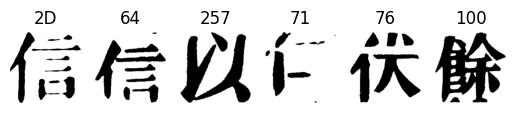

In [29]:
img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
plt.axis('off')
plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
plt.axis('off')
plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])

plt.axis('off')
plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
plt.axis('off')
plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
plt.axis('off')
plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
plt.axis('off')
plt.show()